# Discharge 1 Day all steps


First we are going to open a CSV File containing EFAS Stations.
We will select a random station.

In [1]:
import pandas as pd
from random import sample
stations = pd.read_csv('../static/EFAS_calib_stations_metadata.csv',encoding='iso-8859-1')
station = stations.sample(n=1)
station

,ObsID,StationName,Provider ID,Country code,StationLat,StationLon,Height,Height Units,DrainingArea.km2.Provider,Catchment Area Units,...,DiffDays_hist_6,DiffDays_nrt_6,cal_hist_24h,cal_nrt_24h,cal_hist_6h,cal_nrt_6h,CAL_TYPE,Notes,EC_calib,Dam/Lake
339,622,Flumen En Albalatillo,1012,ES,41.758431,-0.181336,244.47,m,1499,Km2,...,-,2314,TRUE,TRUE,FALSE,TRUE,NRT_6h,-,3,-


We will open a dataset containing the ECMWF Ensemble Forecast (50 members) containg River Dicharge over 24 hours from Step 0 to 360 from the forecast 15th November 2018 00Z

In [2]:
import xarray as xr
ds = xr.open_dataset('../data/eue_15111800.nc')

We can quickly see the variable's of the file using ds.data_vars

In [3]:
ds.data_vars

Data variables:
    dis24                         (number, step, y, x) float32 ...
    lambert_azimuthal_equal_area  int32 ...
    land_binary_mask              (y, x) int8 ...
    upArea                        (y, x) float32 ...

We can check the data_variables dimensions using dis.dims

Number being the number of the Model

In [4]:
ds.dims

Frozen(SortedKeysDict({'y': 950, 'x': 1000, 'number': 50, 'step': 15}))

Now we know the variable and the dimensions we can look at the shape of the variable.

In [5]:
ds.dis24.shape

(50, 15, 950, 1000)

Now we will open the Historical Simulations

In [6]:
clim = xr.open_dataset('../data/clim_151118.nc')
clim


<xarray.Dataset>
Dimensions:                       (time: 15, x: 1000, y: 950)
Coordinates:
  * y                             (y) float64 5.498e+06 5.492e+06 ... 7.525e+05
  * x                             (x) float64 2.502e+06 2.508e+06 ... 7.498e+06
  * time                          (time) datetime64[ns] 2018-11-15T06:00:00 ... 2018-11-29T06:00:00
    step                          timedelta64[ns] ...
    surface                       int64 ...
    latitude                      (y, x) float32 ...
    longitude                     (y, x) float32 ...
    valid_time                    (time) datetime64[ns] ...
Data variables:
    dis24                         (time, y, x) float32 ...
    lambert_azimuthal_equal_area  int32 ...
    land_binary_mask              (y, x) int8 ...
    upArea                        (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    G

<IPython.core.display.Javascript object>


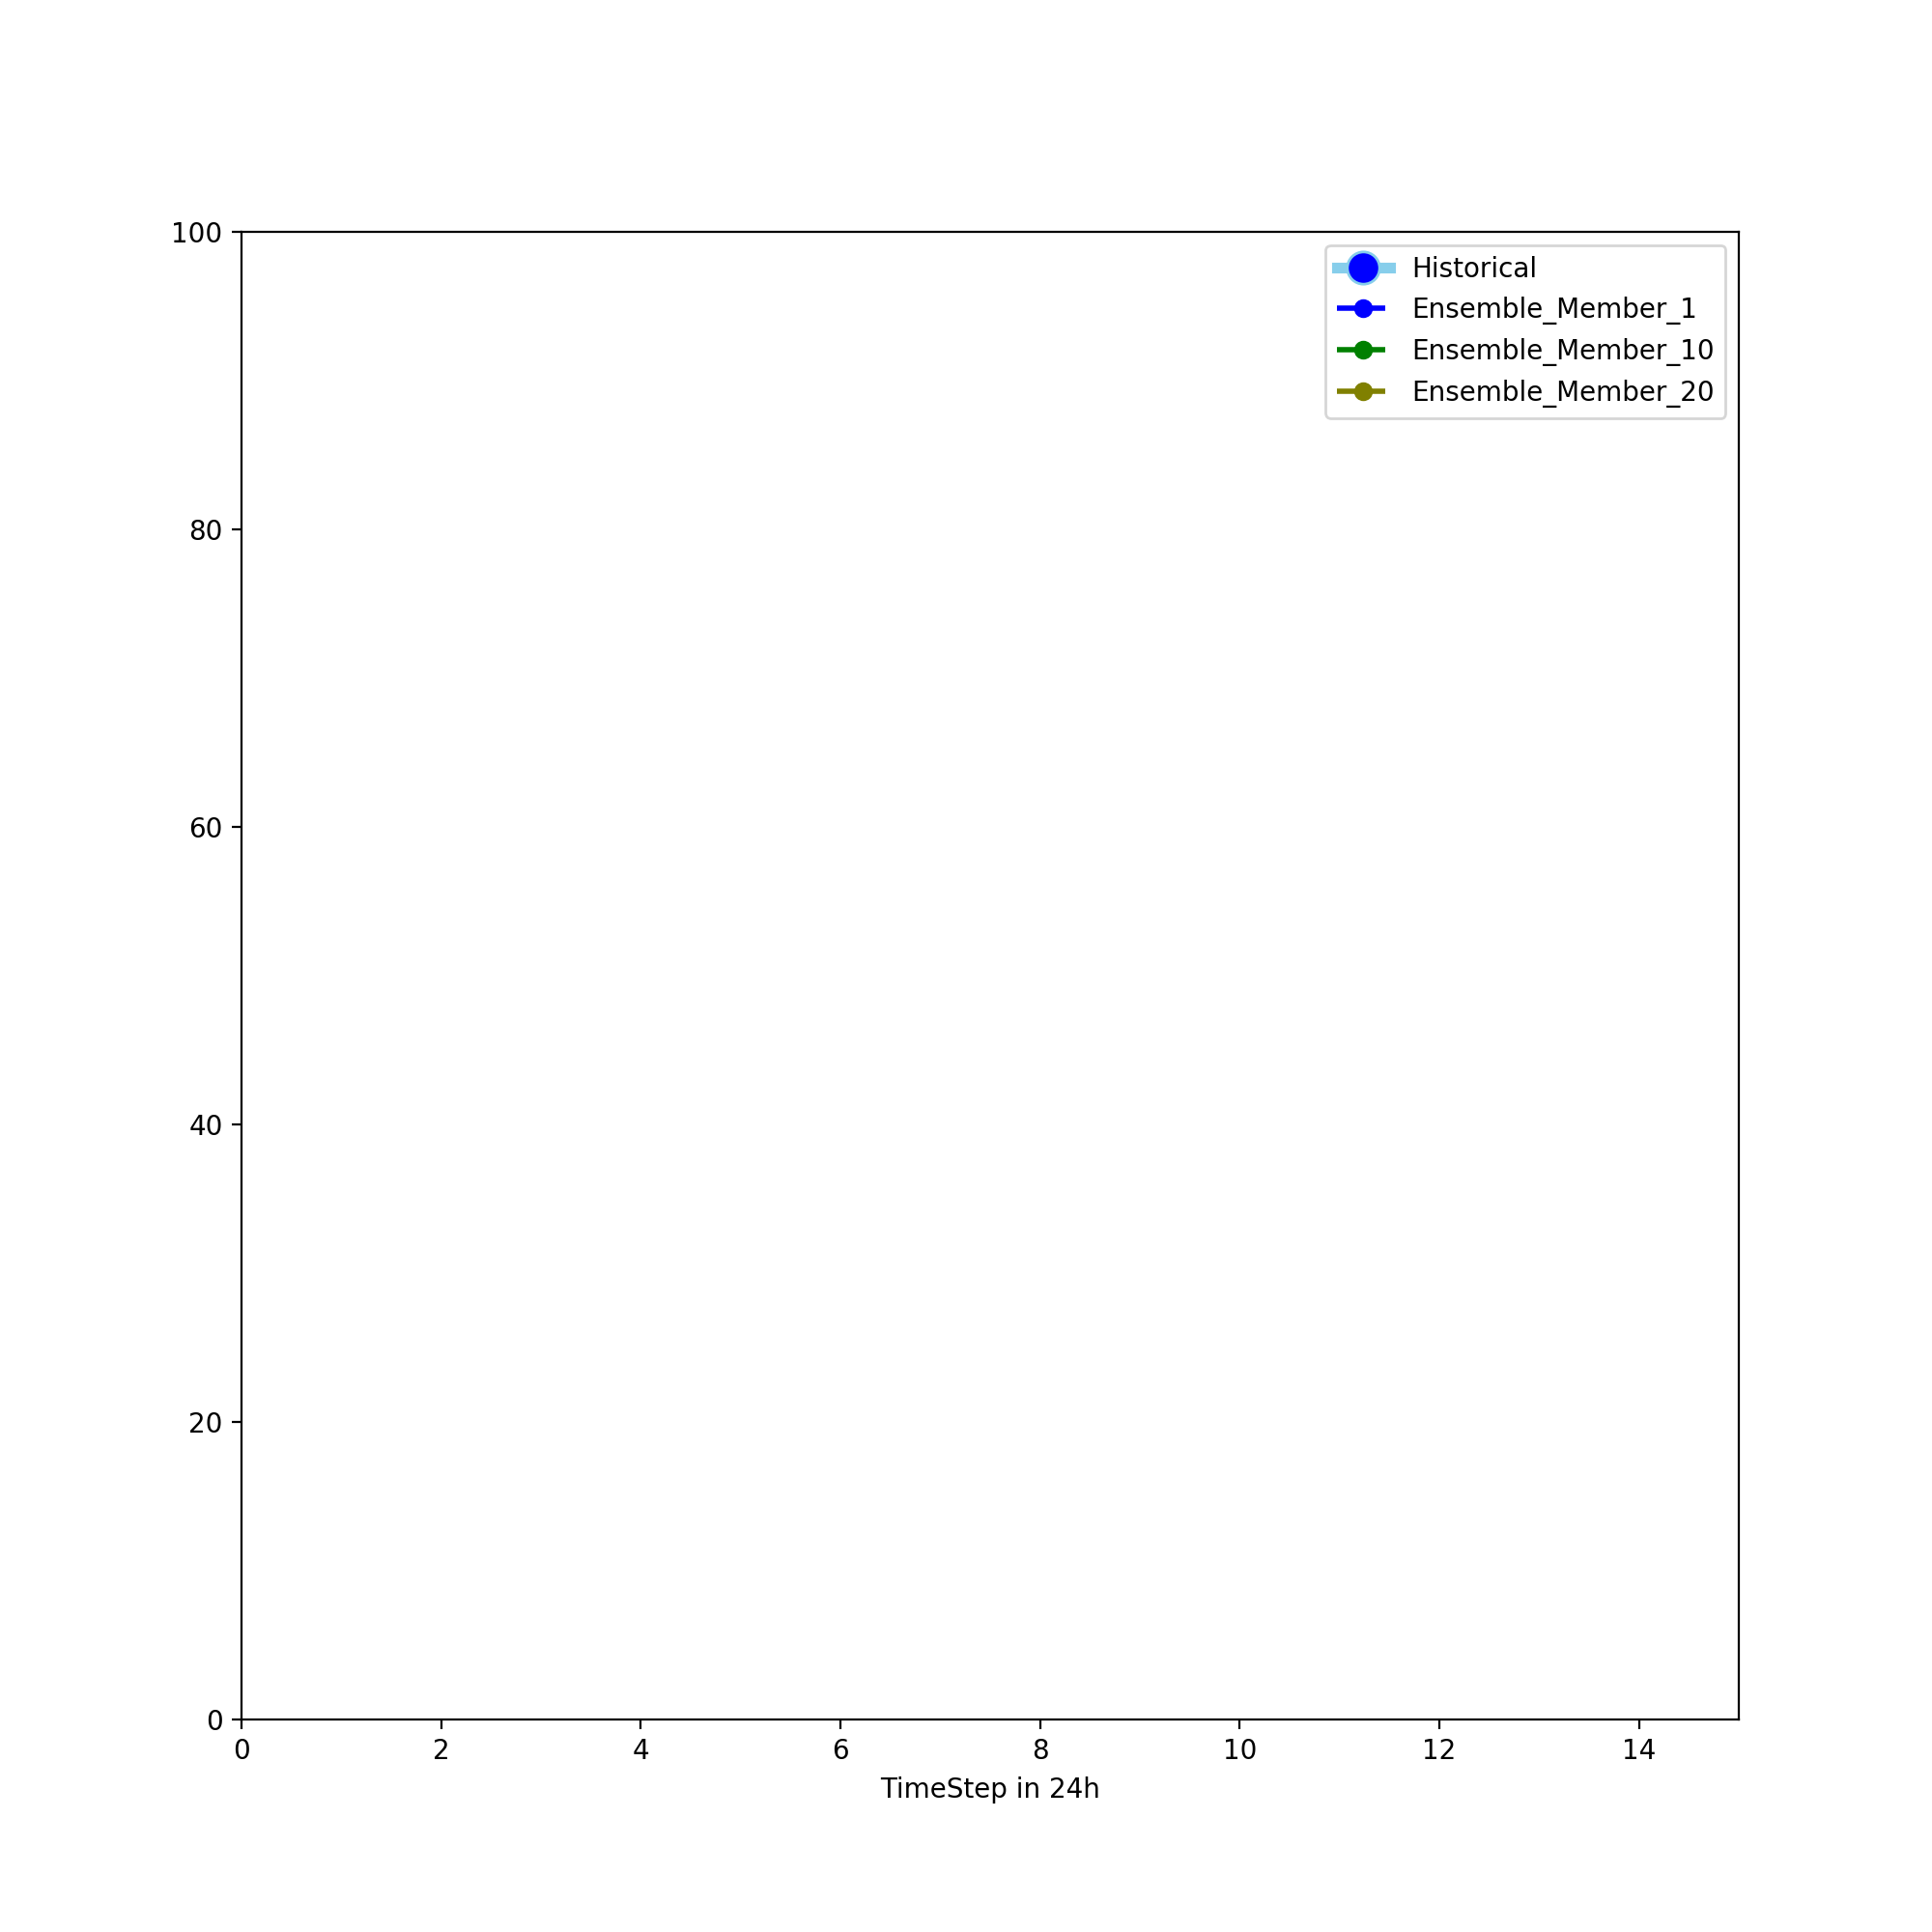

In [13]:
%matplotlib notebook
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plot
import numpy as np
import pyproj

matplotlib.rcParams['figure.figsize'] = [10, 10]

inputEPSG = pyproj.Proj(init='epsg:4326')   # ref susyem EFAS-IS
outputEPSG = pyproj.Proj(init='epsg:3035')  # ref system LISFLOOD

x_lsf, y_lsf = pyproj.transform(inputEPSG, outputEPSG, float(station.StationLon.values), float(station.StationLat.values))

# extract data for selected point in netcdf file by LISFLOOD coordinates
dsloc = ds.sel(x=x_lsf,y=y_lsf,method='nearest')
climloc = clim.sel(x=x_lsf,y=y_lsf,method='nearest')

plot.figure(figsize=(10,10),num='EFAS Data in matplotlib with Jupyter')

plot.xlabel('TimeStep in 24h')
df=pd.DataFrame({'TimeStep': dsloc.step.values, 'Historical': climloc.dis24.values, 'Ensemble_Member_1': dsloc.dis24[0,:].values, 'Ensemble_Member_10': dsloc.dis24[10,:].values, 'Ensemble_Member_20': dsloc.dis24[20,:].values})
plot.plot( 'TimeStep', 'Historical', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plot.plot( 'TimeStep', 'Ensemble_Member_1', data=df, marker='o', color='blue', linewidth=2, linestyle='dashed')
plot.plot( 'TimeStep', 'Ensemble_Member_10', data=df, marker='o', color='green', linewidth=2, linestyle='dashed')
plot.plot( 'TimeStep', 'Ensemble_Member_20', data=df, marker='o', color='olive', linewidth=2, linestyle='dashed')
plot.axis([0,15,0,100])
plot.legend()
plot.show()